In [ ]:
import os
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import time

!pip install pmdarima --quiet

# 1) Download Dataset
import kagglehub
path = kagglehub.dataset_download("ricgomes/global-fashion-retail-stores-dataset")
print("Path to dataset files:", path)

# 2) Function detect file
def find_transactions_file(base_path):
    CAND = ["Transactions.csv", "transactions.csv", "TRANSACTIONS.csv", "Transactions.CSV"]

    for f in CAND:
        fp = os.path.join(base_path, f)
        if os.path.exists(fp):
            return fp

    for root, dirs, files in os.walk(base_path):
        for f in files:
            if "transaction" in f.lower():
                return os.path.join(root, f)

    raise FileNotFoundError(f"transactions file not found in {base_path}")

# 3) Locate CSV
tx_file = find_transactions_file(path)
print("Using file:", tx_file)

# 4) Load file
tx = pd.read_csv(tx_file, low_memory=False)
print("Raw transactions shape:", tx.shape)
print("Columns:", tx.columns.tolist())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 17.7 MB/s eta 0:00:00


100%|██████████| 224M/224M [00:01<00:00, 145MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ricgomes/global-fashion-retail-stores-dataset/versions/24
Using file: /root/.cache/kagglehub/datasets/ricgomes/global-fashion-retail-stores-dataset/versions/24/transactions.csv
Raw transactions shape: (6416827, 19)
Columns: ['Invoice ID', 'Line', 'Customer ID', 'Product ID', 'Size', 'Color', 'Unit Price', 'Quantity', 'Date', 'Discount', 'Line Total', 'Store ID', 'Employee ID', 'Currency', 'Currency Symbol', 'SKU', 'Transaction Type', 'Payment Method', 'Invoice Total']


In [ ]:
import pandas as pd

tx.columns = tx.columns.str.strip()
tx.rename(columns=lambda x: x.replace('\ufeff', ''), inplace=True)

if 'Date' not in tx.columns:
    raise KeyError("Không tìm thấy cột 'Date'. Cột hiện có: " + ", ".join(tx.columns))

tx['Date'] = pd.to_datetime(tx['Date'], errors='coerce')

tx['Revenue_Local'] = pd.to_numeric(tx['Line Total'], errors='coerce').fillna(0)

tx['Revenue_USD'] = tx['Revenue_Local']

negatives = tx[tx['Revenue_Local'] < 0]
print(f"Số giao dịch âm: {len(negatives)}")
if len(negatives) > 0:
    print(negatives.head())

tx = tx.set_index('Date')
daily = (
    tx.groupby("Date")["Revenue_USD"]
      .sum()
      .asfreq("D")
      .fillna(0)
)

print(daily.head(10))


Số giao dịch âm: 339627
              Invoice ID  Line  Customer ID  Product ID Size    Color  \
15   RET-US-001-03558764     1         1968        1208    M   SILVER   
16   RET-US-001-03558764     2         1968        2639    M    WHITE   
31   RET-US-001-03558763     1         8286        1395    M      NaN   
40   RET-US-001-03558767     1        14906        2924  XXL  NEUTRAL   
103  RET-US-001-03558799     1        21979         377    M    LILAC   

     Unit Price  Quantity       Date  Discount  ...  Store ID  Employee ID  \
15         75.0         1 2023-01-01       0.0  ...         1            9   
16         45.5         1 2023-01-01       0.0  ...         1            9   
31         95.5         1 2023-01-01       0.0  ...         1            6   
40         54.0         1 2023-01-01       0.0  ...         1           13   
103        42.0         1 2023-01-01       0.0  ...         1            7   

     Currency Currency Symbol                   SKU Transaction Type

Dữ liệu aggregate (daily):
Date
2023-01-01    1743228.65
2023-01-02     363689.48
2023-01-03     398330.53
2023-01-04     398914.54
2023-01-05     345023.73
2023-01-06     331310.24
2023-01-07     733438.05
2023-01-08     680145.51
2023-01-09     359435.92
2023-01-10     362599.06
Freq: D, Name: Revenue_USD, dtype: float64
Dataset length: 808
Train: 565 Validation: 161 Test: 82
Validation metrics: {'MAE': 757347.7973312715, 'RMSE': np.float64(1019281.4125636695), 'sMAPE': np.float64(78.09272506070815)}
Test metrics: {'MAE': 3996775.8117077393, 'RMSE': np.float64(4209376.210366383), 'sMAPE': np.float64(149.31938510582918)}
Forecast 30 days:
2025-03-19    2.490092e+06
2025-03-20    3.900739e+06
2025-03-21    4.174334e+06
2025-03-22    2.701451e+06
2025-03-23    2.689497e+06
Freq: D, dtype: float64


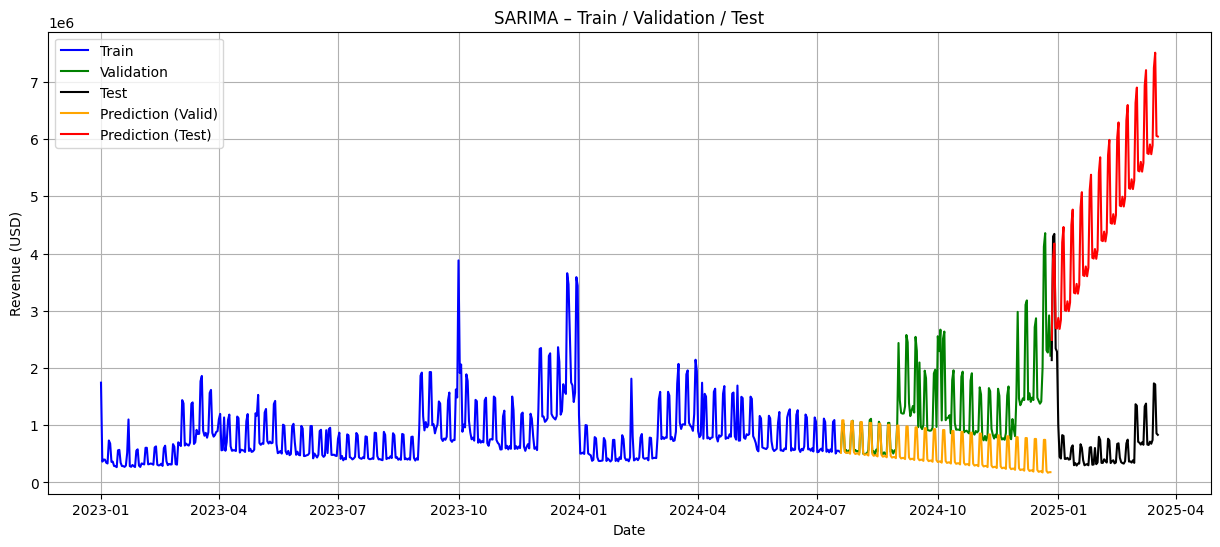

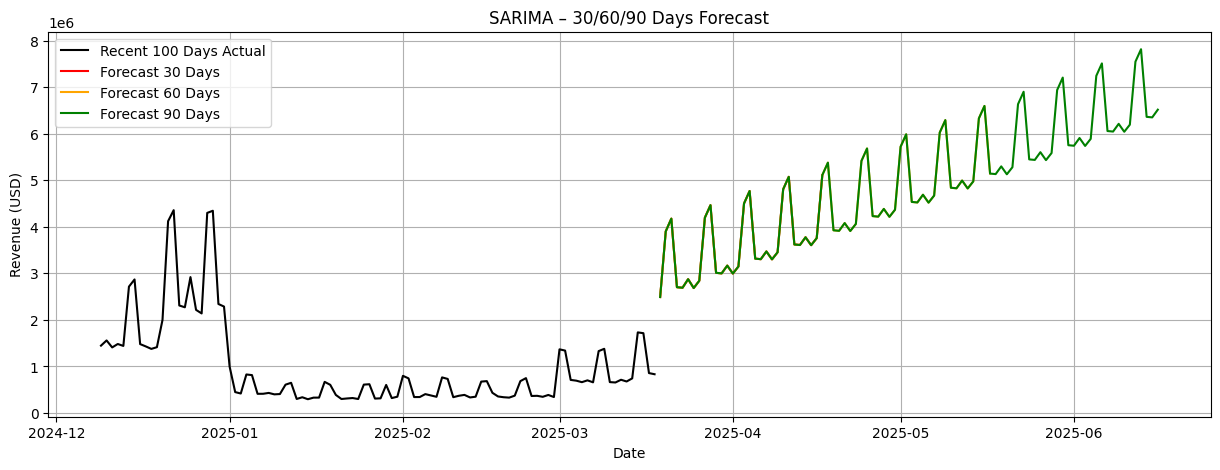

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# --- Cell chuẩn hóa dữ liệu trước đã set index 'Date' ---
# tx đã có index = 'Date', Revenue_USD đã tính sẵn
ts = tx['Revenue_USD'].resample('D').sum().fillna(0)

print("Dữ liệu aggregate (daily):")
print(ts.head(10))

# --- SARIMA split 70/20/10 ---
def sMAPE(y_true, y_pred):
    denom = np.abs(y_true) + np.abs(y_pred)
    denom[denom == 0] = 1
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / denom)

def run_sarima_split(ts, order=(1,1,1), seasonal_order=(1,1,1,7)):
    """
    Train / Validation / Test = 70% - 20% - 10%
    Forecast 30/60/90 days
    """
    ts = ts.asfreq('D').fillna(0)
    n = len(ts)

    n_train = int(n*0.7)
    n_valid = int(n*0.2)
    n_test  = n - n_train - n_valid

    train = ts.iloc[:n_train]
    valid = ts.iloc[n_train:n_train+n_valid]
    test  = ts.iloc[n_train+n_valid:]

    print("Dataset length:", n)
    print("Train:", len(train), "Validation:", len(valid), "Test:", len(test))

    res_train = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

    pred_valid = res_train.get_prediction(start=valid.index[0], end=valid.index[-1], dynamic=False).predicted_mean
    mae_valid = mean_absolute_error(valid, pred_valid)
    rmse_valid = np.sqrt(np.mean((valid - pred_valid)**2))
    smape_valid = sMAPE(valid.values, pred_valid.values)

    ts_train_valid = ts.iloc[:n_train+n_valid]
    res_full = SARIMAX(ts_train_valid, order=order, seasonal_order=seasonal_order,
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

    pred_test = res_full.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False).predicted_mean
    mae_test = mean_absolute_error(test, pred_test)
    rmse_test = np.sqrt(np.mean((test - pred_test)**2))
    smape_test = sMAPE(test.values, pred_test.values)

    # --- Forecast future
    def forecast_future(model_res, days):
        fc = model_res.get_forecast(steps=days)
        idx = pd.date_range(start=ts.index[-1]+pd.Timedelta(days=1), periods=days, freq='D')
        return pd.Series(fc.predicted_mean.values, index=idx)


    return {
        "train": train,
        "valid": valid,
        "test": test,
        "pred_valid": pred_valid,
        "pred_test": pred_test,
        "metrics_valid": {"MAE": mae_valid, "RMSE": rmse_valid, "sMAPE": smape_valid},
        "metrics_test": {"MAE": mae_test, "RMSE": rmse_test, "sMAPE": smape_test},
        "forecast_30": forecast_future(res_full, 30),
        "forecast_60": forecast_future(res_full, 60),
        "forecast_90": forecast_future(res_full, 90)
    }

# --- Chạy SARIMA ---
result = run_sarima_split(ts, order=(1,1,1), seasonal_order=(1,1,1,7))

print("Validation metrics:", result["metrics_valid"])
print("Test metrics:", result["metrics_test"])
print("Forecast 30 days:")
print(result["forecast_30"].head())

# --- Vẽ kết quả ---
def plot_sarima_results(ts, output):
    train = output["train"]
    valid = output["valid"]
    test  = output["test"]
    pred_valid = output["pred_valid"]
    pred_test  = output["pred_test"]
    fc30 = output["forecast_30"]
    fc60 = output["forecast_60"]
    fc90 = output["forecast_90"]

    # Train / Valid / Test + Prediction
    plt.figure(figsize=(15,6))
    plt.plot(train.index, train, label="Train", color="blue")
    plt.plot(valid.index, valid, label="Validation", color="green")
    plt.plot(test.index, test, label="Test", color="black")
    plt.plot(pred_valid.index, pred_valid, label="Prediction (Valid)", color="orange")
    plt.plot(pred_test.index, pred_test, label="Prediction (Test)", color="red")
    plt.title("SARIMA – Train / Validation / Test")
    plt.xlabel("Date")
    plt.ylabel("Revenue (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Future forecast
    plt.figure(figsize=(15,5))
    plt.plot(ts.index[-100:], ts[-100:], label="Recent 100 Days Actual", color="black")
    plt.plot(fc30.index, fc30, label="Forecast 30 Days", color="red")
    plt.plot(fc60.index, fc60, label="Forecast 60 Days", color="orange")
    plt.plot(fc90.index, fc90, label="Forecast 90 Days", color="green")
    plt.title("SARIMA – 30/60/90 Days Forecast")
    plt.xlabel("Date")
    plt.ylabel("Revenue (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_sarima_results(ts, result)


Dữ liệu aggregate (daily):
Date
2023-01-01    1743228.65
2023-01-02     363689.48
2023-01-03     398330.53
2023-01-04     398914.54
2023-01-05     345023.73
2023-01-06     331310.24
2023-01-07     733438.05
2023-01-08     680145.51
2023-01-09     359435.92
2023-01-10     362599.06
Freq: D, Name: Revenue_USD, dtype: float64
Fold 1 metrics: Valid sMAPE=44.37, Test sMAPE=14.57
Fold 2 metrics: Valid sMAPE=31.72, Test sMAPE=12.22
Fold 3 metrics: Valid sMAPE=25.43, Test sMAPE=9.57
Fold 4 metrics: Valid sMAPE=47.39, Test sMAPE=37.45
Fold 5 metrics: Valid sMAPE=137.48, Test sMAPE=75.26
Average metrics across folds:
Validation: {'MAE': 385660.9641524468, 'RMSE': 503960.83363512467, 'sMAPE': 57.27924988517975}
Test: {'MAE': 280246.22865804593, 'RMSE': 311344.1531124307, 'sMAPE': 29.815083025239254}


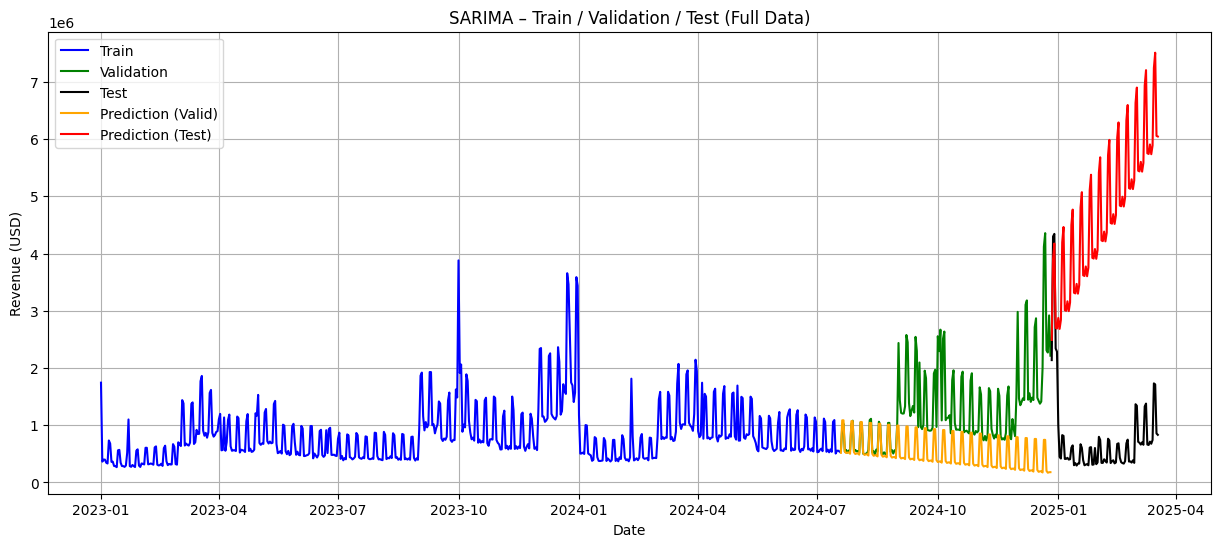

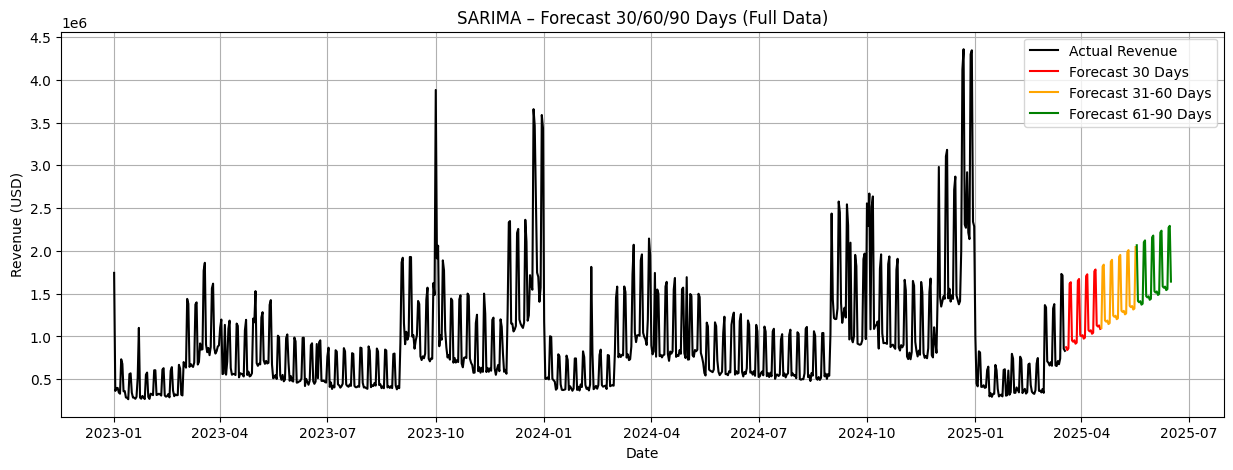

In [ ]:
# --- Import thư viện ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# --- Chuẩn hóa dữ liệu ---
# Giả sử tx đã có index = 'Date' và cột 'Revenue_USD'
ts = tx['Revenue_USD'].resample('D').sum().fillna(0)

print("Dữ liệu aggregate (daily):")
print(ts.head(10))

# --- Hàm sMAPE ---
def sMAPE(y_true, y_pred):
    denom = np.abs(y_true) + np.abs(y_pred)
    denom[denom == 0] = 1
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / denom)

# --- 5-Fold Time Series CV để tính metrics ---
def run_sarima_cv(ts, order=(1,1,1), seasonal_order=(1,1,1,7), n_splits=5):
    ts = ts.asfreq('D').fillna(0)
    n = len(ts)
    fold_size = n // n_splits
    results = []

    for i in range(n_splits):
        start = i * fold_size
        end   = start + fold_size if i < n_splits-1 else n

        fold_ts = ts[start:end]

        n_fold = len(fold_ts)
        n_train = int(n_fold*0.7)
        n_valid = int(n_fold*0.2)
        n_test  = n_fold - n_train - n_valid

        train = fold_ts.iloc[:n_train]
        valid = fold_ts.iloc[n_train:n_train+n_valid]
        test  = fold_ts.iloc[n_train+n_valid:]

        # Train SARIMA trên train
        res_train = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

        pred_valid = res_train.get_prediction(start=valid.index[0], end=valid.index[-1], dynamic=False).predicted_mean

        # Train + Valid để dự đoán test
        ts_train_valid = pd.concat([train, valid])
        res_full = SARIMAX(ts_train_valid, order=order, seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

        pred_test = res_full.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False).predicted_mean

        mae_valid = mean_absolute_error(valid, pred_valid)
        rmse_valid = np.sqrt(np.mean((valid - pred_valid)**2))
        smape_valid = sMAPE(valid.values, pred_valid.values)

        mae_test = mean_absolute_error(test, pred_test)
        rmse_test = np.sqrt(np.mean((test - pred_test)**2))
        smape_test = sMAPE(test.values, pred_test.values)

        results.append({
            "fold": i+1,
            "metrics_valid": {"MAE": mae_valid, "RMSE": rmse_valid, "sMAPE": smape_valid},
            "metrics_test": {"MAE": mae_test, "RMSE": rmse_test, "sMAPE": smape_test}
        })

        print(f"Fold {i+1} metrics: Valid sMAPE={smape_valid:.2f}, Test sMAPE={smape_test:.2f}")

    # Trung bình metrics 5 fold
    avg_metrics_valid = pd.DataFrame([r["metrics_valid"] for r in results]).mean().to_dict()
    avg_metrics_test  = pd.DataFrame([r["metrics_test"] for r in results]).mean().to_dict()

    print("Average metrics across folds:")
    print("Validation:", avg_metrics_valid)
    print("Test:", avg_metrics_test)

    return results, avg_metrics_valid, avg_metrics_test

# --- Chạy 5-fold CV ---
fold_results, avg_valid, avg_test = run_sarima_cv(ts, order=(1,1,1), seasonal_order=(1,1,1,7))

# --- Train / Validation / Test dựa trên toàn bộ dữ liệu ---
n = len(ts)
n_train = int(n*0.7)
n_valid = int(n*0.2)
n_test  = n - n_train - n_valid

train = ts.iloc[:n_train]
valid = ts.iloc[n_train:n_train+n_valid]
test  = ts.iloc[n_train+n_valid:]

# --- Train SARIMA và dự đoán ---
res_train = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7),
                    enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
pred_valid = res_train.get_prediction(start=valid.index[0], end=valid.index[-1], dynamic=False).predicted_mean

ts_train_valid = pd.concat([train, valid])
res_full_train_valid = SARIMAX(ts_train_valid, order=(1,1,1), seasonal_order=(1,1,1,7),
                               enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
pred_test = res_full_train_valid.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False).predicted_mean

# --- Forecast 30/60/90 ngày từ toàn bộ dữ liệu ---
res_full = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,7),
                   enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

def forecast_future(model_res, days):
    fc = model_res.get_forecast(steps=days)
    idx = pd.date_range(start=ts.index[-1]+pd.Timedelta(days=1), periods=days, freq='D')
    return pd.Series(fc.predicted_mean.values, index=idx)

fc30 = forecast_future(res_full, 30)
fc60 = forecast_future(res_full, 60)
fc90 = forecast_future(res_full, 90)

# --- Vẽ Train / Validation / Test + Prediction liền mạch ---
plt.figure(figsize=(15,6))
plt.plot(train.index, train, label="Train", color="blue")
plt.plot(valid.index, valid, label="Validation", color="green")
plt.plot(test.index, test, label="Test", color="black")
plt.plot(pred_valid.index, pred_valid, label="Prediction (Valid)", color="orange")
plt.plot(pred_test.index, pred_test, label="Prediction (Test)", color="red")
plt.title("SARIMA – Train / Validation / Test (Full Data)")
plt.xlabel("Date")
plt.ylabel("Revenue (USD)")
plt.legend()
plt.grid(True)
plt.show()

# --- Vẽ Forecast 30/60/90 ngày ---
plt.figure(figsize=(15,5))
plt.plot(ts.index, ts, label="Actual Revenue", color="black")
plt.plot(fc30.index, fc30, label="Forecast 30 Days", color="red")
plt.plot(fc60.index[30:], fc60[30:], label="Forecast 31-60 Days", color="orange")  # chỉ phần 31-60
plt.plot(fc90.index[60:], fc90[60:], label="Forecast 61-90 Days", color="green")   # chỉ phần 61-90
plt.title("SARIMA – Forecast 30/60/90 Days (Full Data)")
plt.xlabel("Date")
plt.ylabel("Revenue (USD)")
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
# =======================
# Define Metrics
# =======================
from sklearn.metrics import mean_absolute_error
import numpy as np

def MAPE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    eps = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))


# =======================
# 1) Metrics – TRAIN
# =======================
pred_train = res_train.get_prediction(start=train.index[0],
                                      end=train.index[-1],
                                      dynamic=False).predicted_mean

mae_train = mean_absolute_error(train, pred_train)
rmse_train = RMSE(train, pred_train)
mape_train = MAPE(train, pred_train)


# =======================
# 2) Metrics – VALID
# =======================
mae_valid = mean_absolute_error(valid, pred_valid)
rmse_valid = RMSE(valid, pred_valid)
mape_valid = MAPE(valid, pred_valid)


# =======================
# 3) Metrics – TEST
# =======================
mae_test = mean_absolute_error(test, pred_test)
rmse_test = RMSE(test, pred_test)
mape_test = MAPE(test, pred_test)


# =======================
# 4) Metrics – FULL MODEL
#    (fit toàn bộ TS và dự đoán lại toàn bộ)
# =======================
full_pred = res_full.get_prediction(start=ts.index[0],
                                    end=ts.index[-1],
                                    dynamic=False).predicted_mean

mae_full = mean_absolute_error(ts, full_pred)
rmse_full = RMSE(ts, full_pred)
mape_full = MAPE(ts, full_pred)


# =======================
# PRINT RESULT
# =======================
print("\n================ SARIMA METRICS ================\n")
print(f"TRAIN  → MAE={mae_train:.2f}, RMSE={rmse_train:.2f}, MAPE={mape_train:.2f}%")
print(f"VALID  → MAE={mae_valid:.2f}, RMSE={rmse_valid:.2f}, MAPE={mape_valid:.2f}%")
print(f"TEST   → MAE={mae_test:.2f}, RMSE={rmse_test:.2f}, MAPE={mape_test:.2f}%")
print(f"FULL   → MAE={mae_full:.2f}, RMSE={rmse_full:.2f}, MAPE={mape_full:.2f}%")
print("\n===============================================\n")



================ SARIMA METRICS ================

TRAIN  → MAE=153441.80, RMSE=276515.65, MAPE=20.21%
VALID  → MAE=757347.80, RMSE=1019281.41, MAPE=51.13%
TEST   → MAE=3996775.81, RMSE=4209376.21, MAPE=800.44%
FULL   → MAE=168879.74, RMSE=302883.30, MAPE=21.14%


